# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [307]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [308]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [309]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier00.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [310]:
df_Wine.shape

(3304, 25)

In [311]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [312]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [313]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [314]:
df_GeoCache.shape

(1228, 8)

In [315]:
df_Flag.shape

(19, 3)

In [316]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
1476,2006,75,2003,96.0,155,Paul Jaboulet Aîné,Hermitage La Chapelle,Red,Shiraz | Syrah,NaN,...,2008.0,2030.0,"Deceptively graceful at first, with a Burgundy...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
799,2013,98,2011,94.0,150,Château d'Yquem,Bordeaux White Y,White,Blend,Sauvignon Blanc – Semillon,...,2013.0,2023.0,"Creamy and caressing overall, with brioche and...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
308,2017,9,2015,95.0,75,Pahlmeyer,Chardonnay Napa Valley,White,Chardonnay,NaN,...,2017.0,2022.0,"This offers a gorgeous mouthful of rich, butte...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
2533,1995,32,1993,92.0,18,Rombauer,Chardonnay Carneros,White,Chardonnay,NaN,...,NaN,NaN,"Serves up lots of ripe and juicy pear, fig and...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
2642,1994,40,1992,94.0,81,Bouchard Père & Fils,Chevalier-Montrachet,White,Chardonnay,NaN,...,NaN,NaN,It flies over the palate as delicately as a gl...,Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
1453,2006,52,2004,92.0,19,Zind-Humbrecht,Gewürztraminer Alsace,White,Gewürztraminer,NaN,...,2006.0,2012.0,"Complex and exotic, offering dried lychee, ora...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
2295,1998,44,1995,90.0,16,Castello di Monsanto,Chianti Classico Riserva,Red,Chianti,NaN,...,2000.0,NaN,"Full-bodied, rich, traditional-style Chianti, ...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
486,2016,86,2012,93.0,36,Vigneti del Vulture,Aglianico del Vulture Piano del Cerro,Red,Aglianico,NaN,...,2016.0,2027.0,A dense and tarry red that glides on the silky...,Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
615,2014,14,2011,95.0,120,Fontodi,Colli della Toscana Centrale Flaccianello,Red,Sangiovese,NaN,...,2017.0,2030.0,"Aromas and flavors of violet, black currant, r...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
789,2013,88,NV,92.0,48,Pierre Paillard,Brut Champagne,Sparkling,Champagne,NaN,...,2013.0,2020.0,"Shows lovely balance, with a satiny quality to...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0


## Vintage Wines were Cases Made was Non-Zero

In [317]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [318]:
# drop the non-numeric price row from the dataset
df_Wine = df_Wine[df_Wine.Price != '$49 / 500ml']

In [319]:
# Convert data type of price to numeric
df_Wine['Price'].astype(float)

0       139.0
1        85.0
2        90.0
3       135.0
4        90.0
5        90.0
6        53.0
7        99.0
8        95.0
9       175.0
10       40.0
11       40.0
12       45.0
13       52.0
14      110.0
15       60.0
16       23.0
17       35.0
18       35.0
19       28.0
20       12.0
21       40.0
22       17.0
23       71.0
24       18.0
25       24.0
26       70.0
27       22.0
28       40.0
29       15.0
        ...  
3273     47.0
3274     50.0
3275     41.0
3276      9.0
3277      8.0
3278     22.0
3279     93.0
3280      7.0
3281     12.0
3282     10.0
3283      9.0
3284     10.0
3285     14.0
3286     11.0
3287     12.0
3288     14.0
3289     14.0
3290      6.0
3291      7.0
3292      7.0
3293      7.0
3294      8.0
3295     11.0
3296     17.0
3297     18.0
3298     16.0
3299     30.0
3300      9.0
3301     15.0
3302    150.0
Name: Price, Length: 3302, dtype: float64

In [320]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value

df_Wine_V = df_Wine[
    (df_Wine.Vintage != 'NV') &
    (df_Wine.Cases_Made != 0)
]

df_Wine_V.shape

(2666, 25)

In [321]:
# Average Cases Made by Wine Style - All Years
df_CM_All = pd.DataFrame({'Avg_Cases_Made' : df_Wine_V.groupby(['Wine_Style'])['Cases_Made'].mean()}).reset_index()
df_CM_All

,Wine_Style,Avg_Cases_Made
0,Dessert & Fortified,6936.120690
1,Red,9303.433141
2,Rosé | Rosado,12566.571429
3,Sparkling,6874.969697
4,White,12529.951589


In [322]:
# Average Cases Made by Wine Style - By Vintage Year
df_CM_ByYear = pd.DataFrame({'Avg_Cases_Made' : df_Wine_V.groupby(['Vintage', 'Wine_Style'])['Cases_Made'].mean()}).reset_index()
df_CM_ByYear.sample(10)

,Vintage,Wine_Style,Avg_Cases_Made
44,1996,White,12278.529412
115,2017,Dessert & Fortified,3500.000000
9,1987,Red,4269.578947
48,1997,White,13308.195122
8,1986,White,2381.000000
92,2011,Rosé | Rosado,21000.000000
29,1993,Dessert & Fortified,9000.000000
124,2019,White,32635.714286
42,1996,Red,12322.100000
55,2000,Dessert & Fortified,6812.500000


### Visualization

In [323]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

Text(0.5, 1.1, 'Average Cases Made by Wine Style')

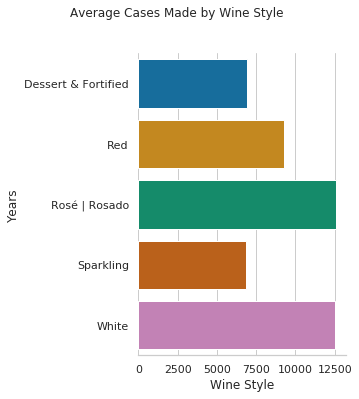

In [324]:
# bar plot of summary data

g = sns.catplot(
    data = df_CM_All,
    kind = 'bar',
    y = 'Wine_Style',
    x = 'Avg_Cases_Made'
)

g.despine(left = True)
g.set_axis_labels('Wine Style', 'Years')

plt.suptitle('Average Cases Made by Wine Style', y = 1.1)

In [325]:
# define a function to plot cases made by year by wine style

def cmby(wine_style):
    df = df_CM_ByYear[
        (df_CM_ByYear['Wine_Style'] == wine_style )
    ]
    
    # set palette and dimensions
    palette = sns.color_palette('colorblind')
    
    dim = (8, 10)
    fig, ax = plt.subplots(figsize = dim)
    
    g = sns.barplot(
        data = df,
        orient = 'h',
        y = 'Vintage',
        x = 'Avg_Cases_Made'
    )
    
    plt.suptitle(wine_style + '\nAverage Number of Cases Made by Vintage Year', y = 1)

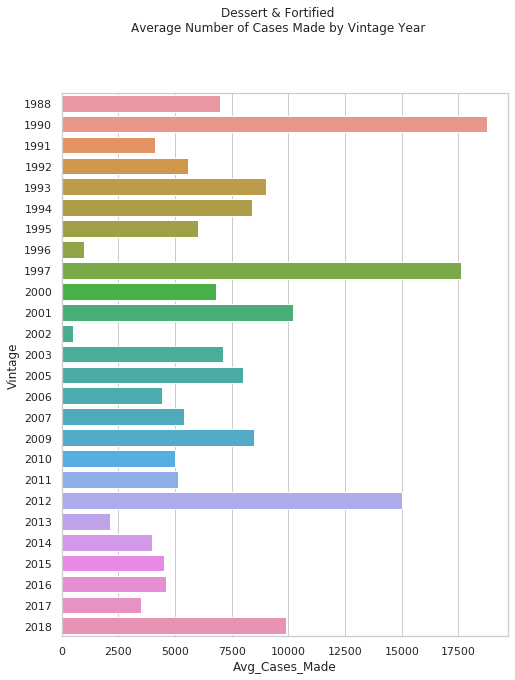

In [326]:
cmby('Dessert & Fortified')

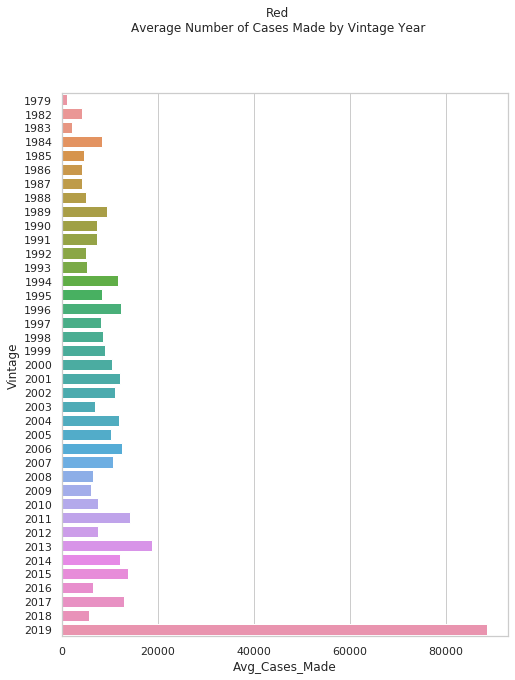

In [327]:
cmby('Red')

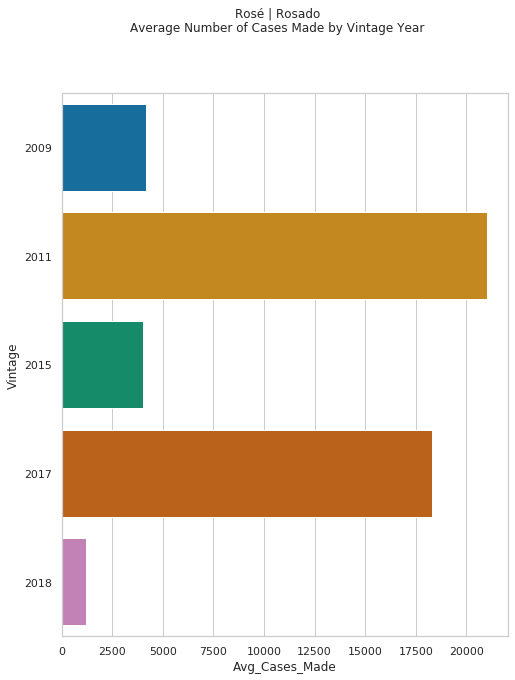

In [328]:
cmby('Rosé | Rosado')

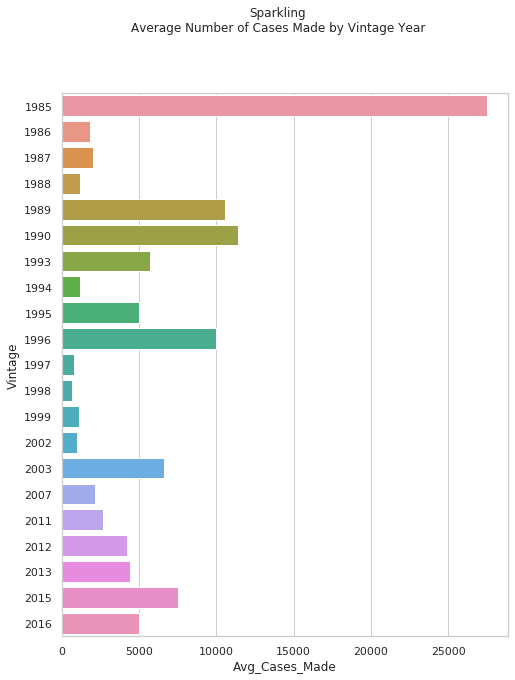

In [329]:
cmby('Sparkling')

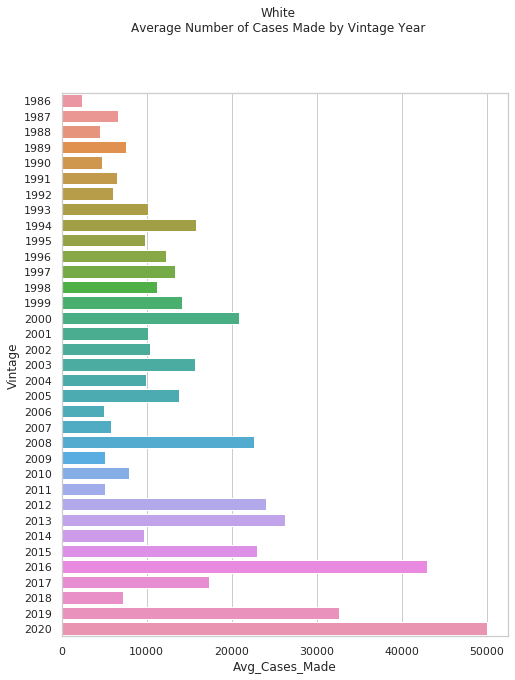

In [330]:
cmby('White')

In [331]:
# Create a dataset that allows for next-level analysis

df_CMBYBC = pd.DataFrame({'Avg_Cases_Made' : df_Wine_V.groupby(['Vintage', 'Wine_Style', 'Address'])['Cases_Made'].mean()})
df_CMBYBC = df_CMBYBC.reset_index()
df_CMBYBC.head()

,Vintage,Wine_Style,Address,Avg_Cases_Made
0,1979,Red,Spain,1000.0
1,1982,Red,Australia,5000.0
2,1982,Red,Spain,3500.0
3,1983,Red,Portugal,2224.0
4,1984,Red,USA,8465.0


In [332]:
# Write functions to explore specific vintage years by wine style and by country

def cmbybc(wine_style, vintage):
    df = df_CMBYBC[
        (df_CMBYBC['Wine_Style'] == wine_style ) &
        (df_CMBYBC['Vintage'] == vintage)
    ]
    
    # set palette and dimensions
    palette = sns.color_palette('colorblind')
    
    #dim = (8, 10)
    #fig, ax = plt.subplots(figsize = dim)
    
    g = sns.barplot(
        data = df,
        orient = 'h',
        y = 'Address',
        x = 'Avg_Cases_Made'
    )
    
    plt.suptitle(wine_style + '\nAverage Number of Cases Made by Country in ' + vintage, y = 1)
    
def cmbybc_table(wine_style, vintage):
    df = df_Wine_V[
        (df_Wine_V['Wine_Style'] == wine_style ) &
        (df_Wine_V['Vintage'] == vintage)
    ]
    
    print(df[['Review_Year', 'Rank', 'Vintage', 'Score', 'Price', 'Winemaker', 'Wine', 'Wine_Style', 'Grape_Blend', 'Cases_Made', 'Cases_Imported', 'Geography', 'Address']])

In [333]:
# Explore Red wines, 2019
cmbybc_table('Red', '2019')

    Review_Year Rank Vintage  Score Price          Winemaker  \
42         2020   43    2019   90.0    13  Domaine Bousquet    

                 Wine Wine_Style Grape_Blend  Cases_Made  Cases_Imported  \
42  Malbec Tupungato         Red     Malbec      88540.0         27793.0   

    Geography    Address  
42  Tupungato  Argentina  


In [334]:
# Explore Sparkling Wines, 1985
cmbybc_table('Sparkling', '1985')

      Review_Year Rank Vintage  Score Price  Winemaker  \
3019         1990   17    1985   96.0    45  Bollinger   
3037         1990   35    1985   93.0    37     Lanson   

                             Wine Wine_Style Grape_Blend  Cases_Made  \
3019  Brut Champagne Grande Année  Sparkling   Champagne     15000.0   
3037    Brut Champagne Gold Label  Sparkling   Champagne     40000.0   

      Cases_Imported  Geography Address  
3019             0.0  Champagne  France  
3037             0.0  Champagne  France  


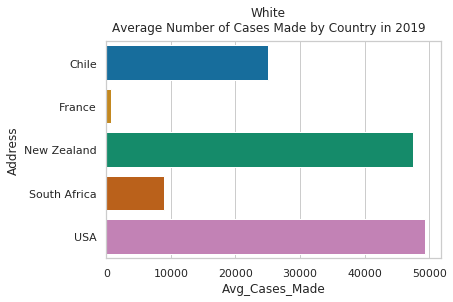

In [335]:
# Explore White Wines, 2019
cmbybc('White', '2019')

In [336]:
# Explore White Wines, 2019
cmbybc_table('White', '2019')

    Review_Year Rank Vintage  Score Price        Winemaker  \
20         2020   21    2019   92.0    12       Joel Gott    
49         2020   50    2019   90.0    14      Los Vascos    
58         2020   59    2019   90.0    16  Southern Right    
65         2020   66    2019   90.0    20           Invivo   
72         2020   73    2019   90.0    20      Spy Valley    
83         2020   84    2019   94.0    35           Delas    
93         2020   94    2019   90.0    15   Klinker Brick    

                                                 Wine Wine_Style  \
20                        Sauvignon Blanc California       White   
49                 Sauvignon Blanc Casablanca Valley       White   
58                        Sauvignon Blanc Walker Bay       White   
65  Sauvignon Blanc Marlborough X, Sarah Jessica P...      White   
72                       Sauvignon Blanc Marlborough       White   
83                     St.-Joseph White Les Challeys       White   
93                         

In [337]:
# Explore White Wines, 2020
cmbybc_table('White', '2020')

    Review_Year Rank Vintage  Score Price     Winemaker  \
22         2020   23    2020   92.0    17  Allan Scott    

                            Wine Wine_Style      Grape_Blend  Cases_Made  \
22  Sauvignon Blanc Marlborough       White  Sauvignon Blanc     50000.0   

    Cases_Imported    Geography      Address  
22         16000.0  Marlborough  New Zealand  


## Vintage Wines were Cases Made and Cases Imported were Non-Zero

In [338]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value and a Cases_Imported Value

df_Wine_VC = df_Wine[
    (df_Wine.Vintage != 'NV') &
    (df_Wine.Cases_Made != 0) &
    (df_Wine.Cases_Imported != 0)
]

df_Wine_VC.shape

(92, 25)

In [339]:
# Calculate Cases Imported as percentage of Cases Made

df_Wine_VC['Case_Ratio'] = df_Wine_VC['Cases_Imported'] / df_Wine_VC['Cases_Made']

/home/elizabethwotawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [340]:
df_Wine_VC.head()

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude,Case_Ratio
0,2020,1,2010,96.0,139,Bodegas Marqués de Murrieta,Rioja Castillo Ygay Gran Reserva Especial,Red,Blend,Tempranillo and Mazuelo.,...,2030.0,"Maturing well, this round red is a lovely exam...",Hierarchy_00,Spain,España,"(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065,0.0,0.090667
2,2020,3,2015,97.0,90,San Filippo,Brunello di Montalcino Le Lucére,Red,Brunello di Montalcino,0,...,2043.0,"Effusive aromas of black currant, blueberry, v...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,0.500000
4,2020,5,2016,96.0,90,Domaine de la Vieille Julienne,Châteauneuf-du-Pape Les Trois Sources,Red,Châteauneuf-du-Pape,0,...,2040.0,"A lush, ripe style, with açaí berry, blueberry...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0,0.250000
6,2020,7,2016,95.0,53,Massolino,Barolo,Red,Blend,Nebbiolo,...,2045.0,"A stream of pure, juicy cherry fruit is at the...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,0.362069
10,2020,11,2016,97.0,40,Castello di Volpaia,Chianti Classico Riserva,Red,Chianti,0,...,2040.0,"Enticing aromas of black cherry, black currant...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,0.550000


In [341]:
# Stack case information - Cases Made by Wine Style

df_CMWS = pd.DataFrame({'Avg_Cases' : df_Wine_V.groupby(['Vintage', 'Wine_Style'])['Cases_Made'].mean()})
df_CMWS = df_CMWS.reset_index()
df_CMWS['Case_Desc'] = 'Cases Made'
df_CMWS.head()

,Vintage,Wine_Style,Avg_Cases,Case_Desc
0,1979,Red,1000.000000,Cases Made
1,1982,Red,4250.000000,Cases Made
2,1983,Red,2224.000000,Cases Made
3,1984,Red,8465.000000,Cases Made
4,1985,Red,4617.896552,Cases Made


In [342]:
# Stack case information - Cases Imported by Wine Style

df_CIWS = pd.DataFrame({'Avg_Cases' : df_Wine_V.groupby(['Vintage', 'Wine_Style'])['Cases_Imported'].mean()})
df_CIWS = df_CIWS.reset_index()
df_CIWS['Case_Desc'] = 'Cases Imported'
df_CIWS.head()

,Vintage,Wine_Style,Avg_Cases,Case_Desc
0,1979,Red,0.0,Cases Imported
1,1982,Red,0.0,Cases Imported
2,1983,Red,0.0,Cases Imported
3,1984,Red,0.0,Cases Imported
4,1985,Red,0.0,Cases Imported


In [343]:
# Concatenate Cases Made, Cases Imported data frames by Wine Style

frames = [df_CMWS, df_CIWS]
df_Cases_WS = pd.concat(frames)
df_Cases_WS.head()

,Vintage,Wine_Style,Avg_Cases,Case_Desc
0,1979,Red,1000.000000,Cases Made
1,1982,Red,4250.000000,Cases Made
2,1983,Red,2224.000000,Cases Made
3,1984,Red,8465.000000,Cases Made
4,1985,Red,4617.896552,Cases Made


In [344]:
# Stack case information - Cases Made by Address

df_CMA = pd.DataFrame({'Avg_Cases' : df_Wine_VC.groupby(['Vintage', 'Address'])['Cases_Made'].mean()})
df_CMA = df_CMA.reset_index()
df_CMA['Case_Desc'] = 'Cases Made'
df_CMA.head()

,Vintage,Address,Avg_Cases,Case_Desc
0,2010,Spain,7500.0,Cases Made
1,2013,Italy,15000.0,Cases Made
2,2013,Spain,26500.0,Cases Made
3,2015,Chile,4500.0,Cases Made
4,2015,France,29166.5,Cases Made


In [345]:
# Stack case information - Cases Imported by Address

df_CIA = pd.DataFrame({'Avg_Cases' : df_Wine_VC.groupby(['Vintage', 'Address'])['Cases_Imported'].mean()})
df_CIA = df_CIA.reset_index()
df_CIA['Case_Desc'] = 'Cases Imported'
df_CIA.head()

,Vintage,Address,Avg_Cases,Case_Desc
0,2010,Spain,680.0,Cases Imported
1,2013,Italy,3000.0,Cases Imported
2,2013,Spain,15900.0,Cases Imported
3,2015,Chile,500.0,Cases Imported
4,2015,France,5350.0,Cases Imported


In [346]:
# Concatenate Cases Made, Cases Imported data frames by Address

frames = [df_CMA, df_CIA]
df_Cases_A = pd.concat(frames)
df_Cases_A.head()

,Vintage,Address,Avg_Cases,Case_Desc
0,2010,Spain,7500.0,Cases Made
1,2013,Italy,15000.0,Cases Made
2,2013,Spain,26500.0,Cases Made
3,2015,Chile,4500.0,Cases Made
4,2015,France,29166.5,Cases Made


In [386]:
# Write functions to explore specific vintage years by wine style and by country

def gpbar(style_or_address, spec_style_or_address):
    
    if style_or_address == 'style':
        df = df_Cases_WS[(df_Cases_WS.Wine_Style == spec_style_or_address)]
        header = 'Wine Style: ' + spec_style_or_address
    elif style or address == 'address':
        df = df_Cases_A[(df_Cases_A.Address == spec_style_or_address)]
        header = 'Geography: ' +  spec_style_or_address
    else:
        print('select style or address')
        
    dim = (8, 10)
    fig, ax = plt.subplots(figsize = dim)
    
    # set palette and dimensions
    palette = sns.color_palette('colorblind')
    
    g = sns.barplot(
        data = df,
        orient = 'h',
        y = 'Vintage',
        x = 'Avg_Cases',
        hue = 'Case_Desc',
    )

    plt.suptitle(header + '\nAverage Number of Cases Made and Imported by Vintage', y = 1)

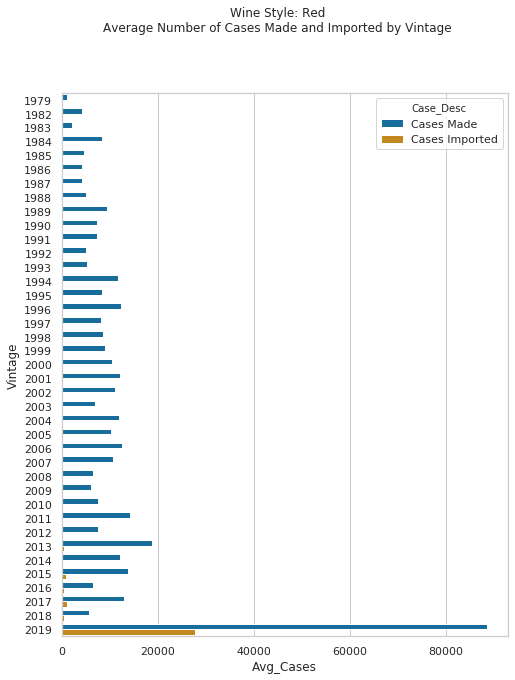

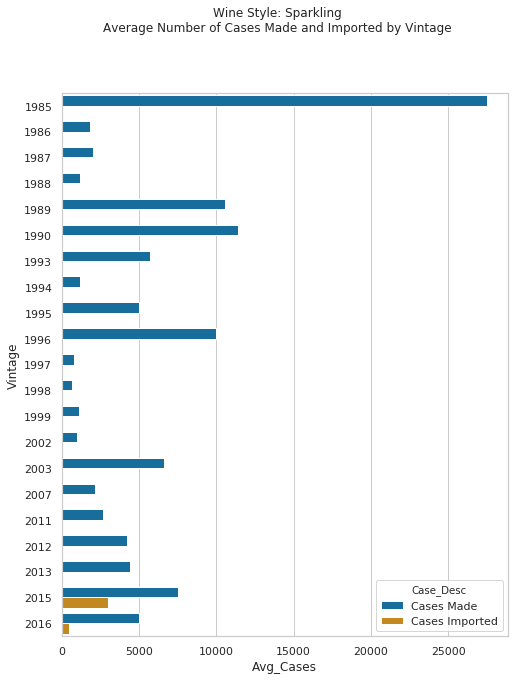

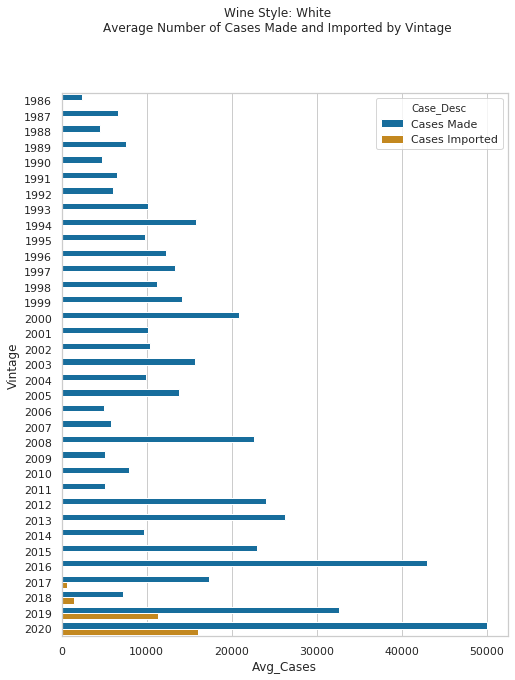

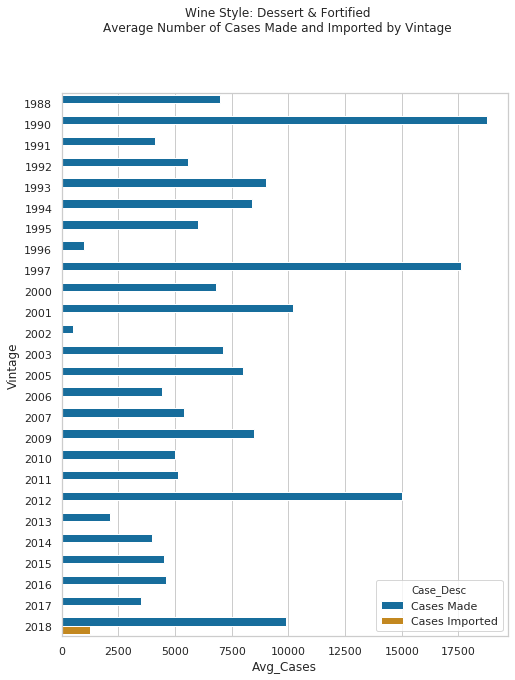

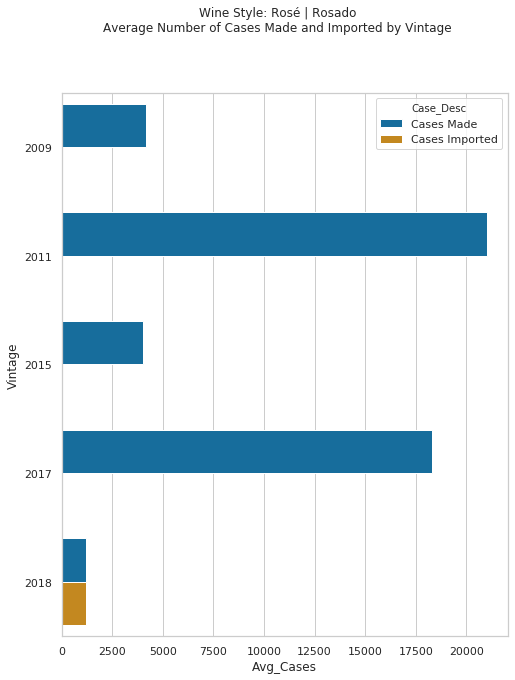

In [390]:
styles = df_Cases_WS.Wine_Style.unique()
styles

for style in styles:
    gpbar('style', style)

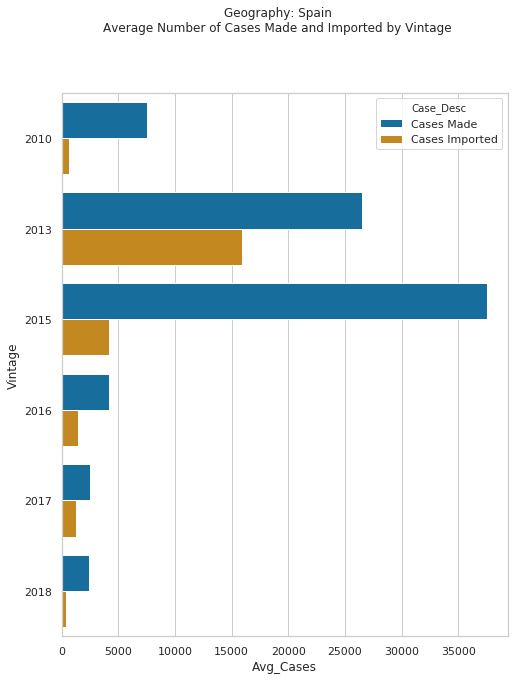

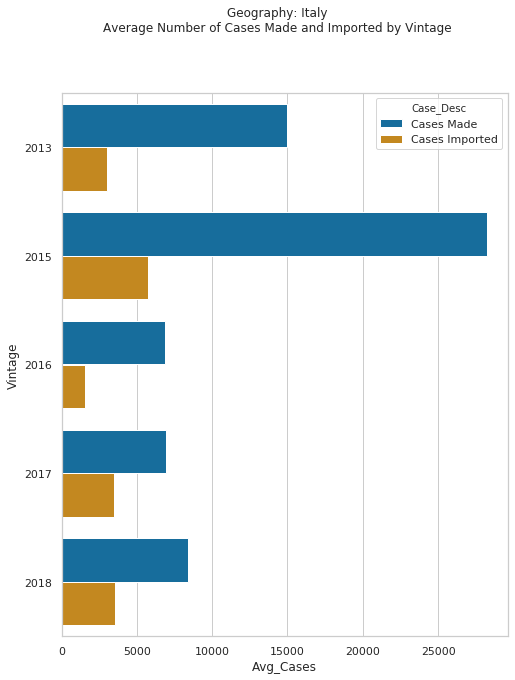

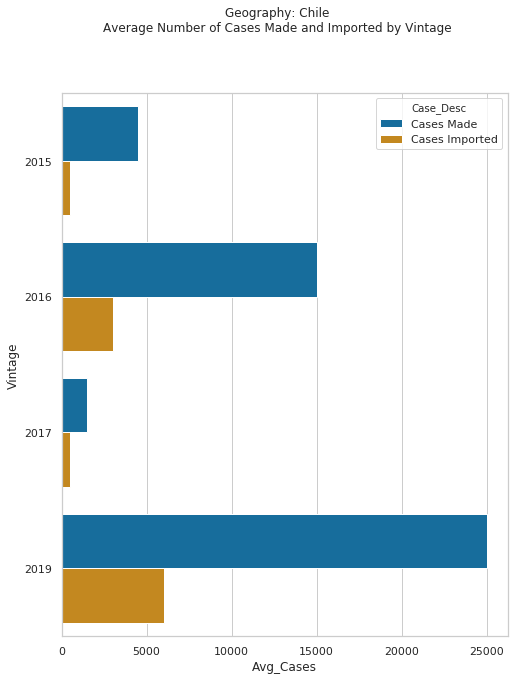

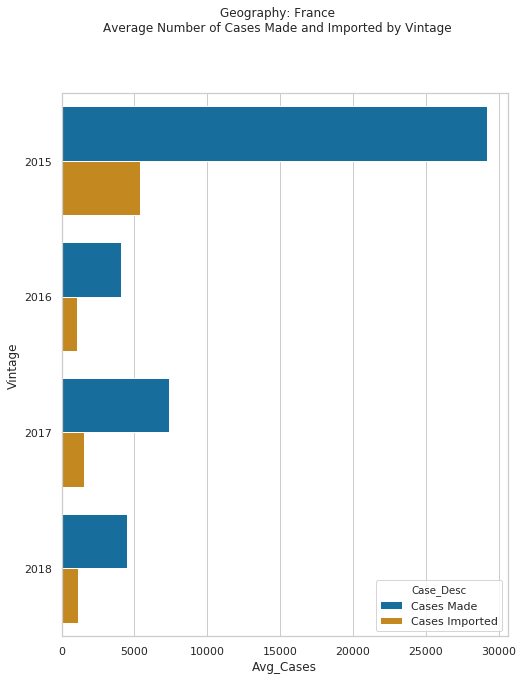

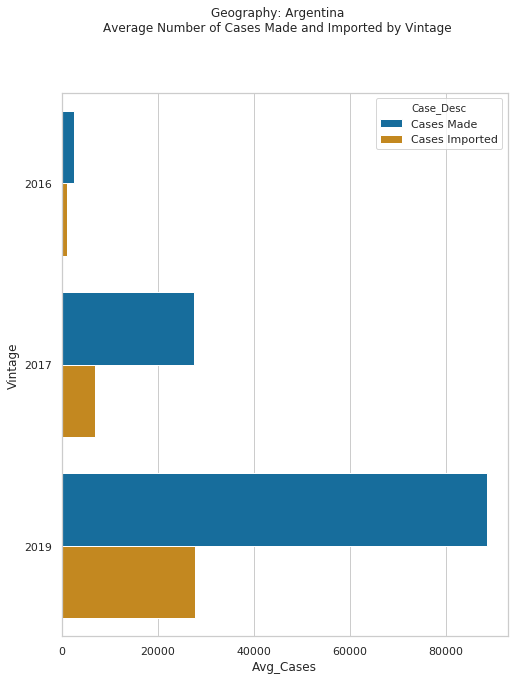

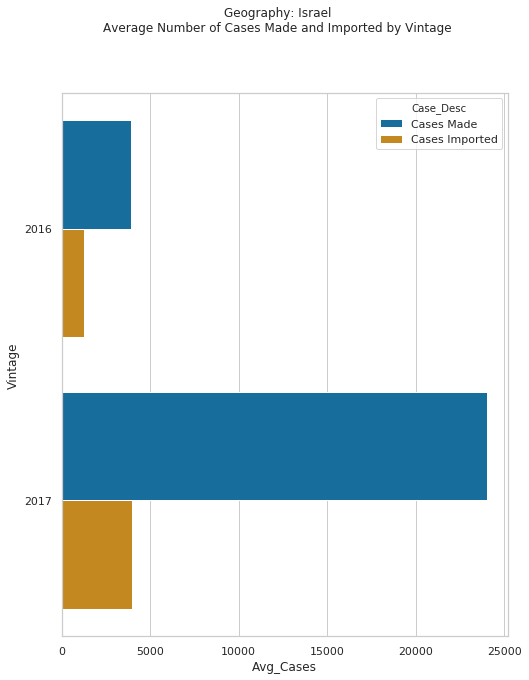

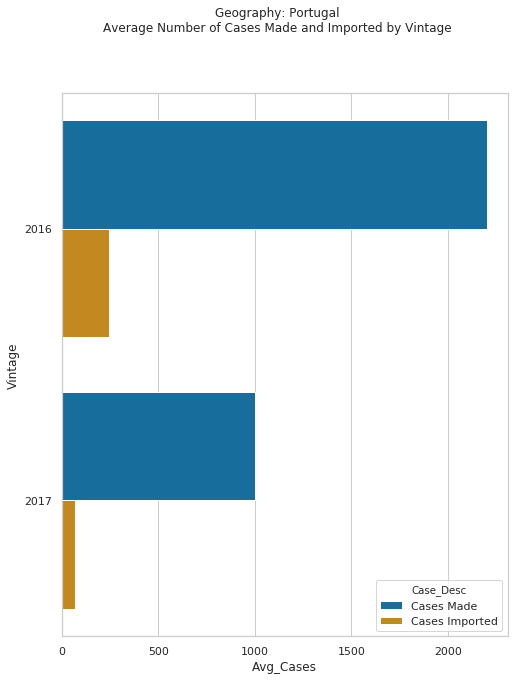

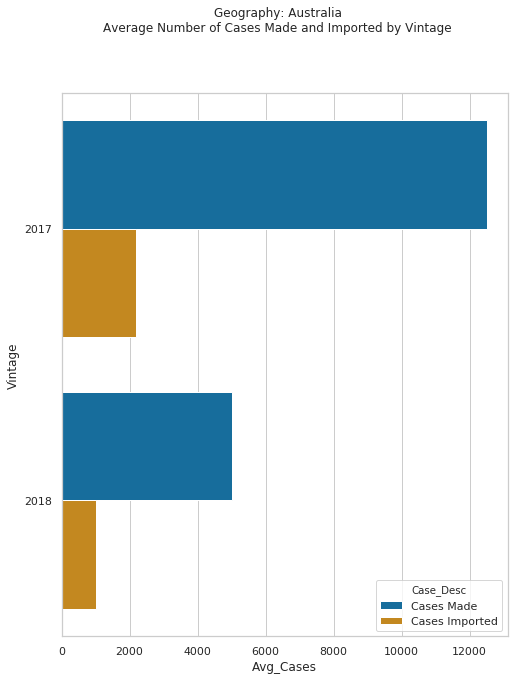

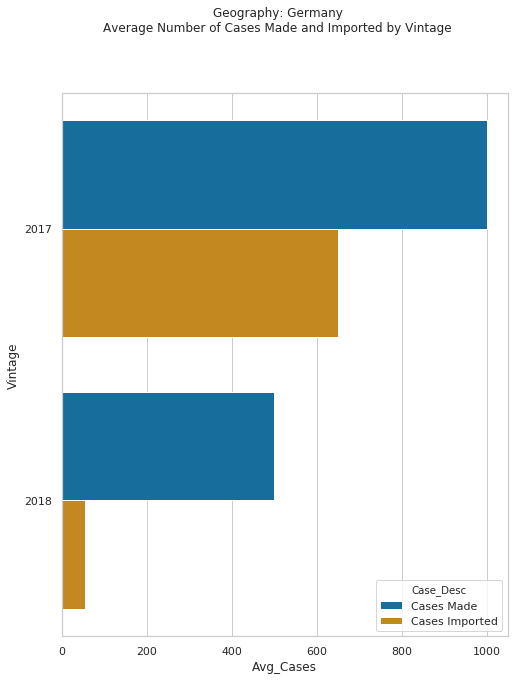

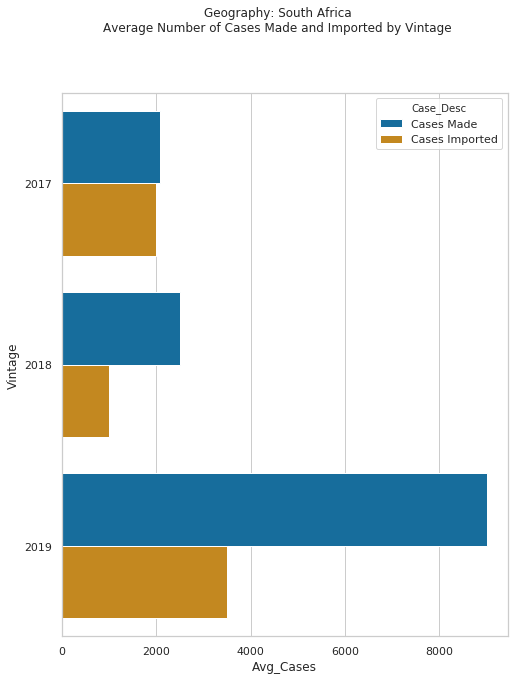

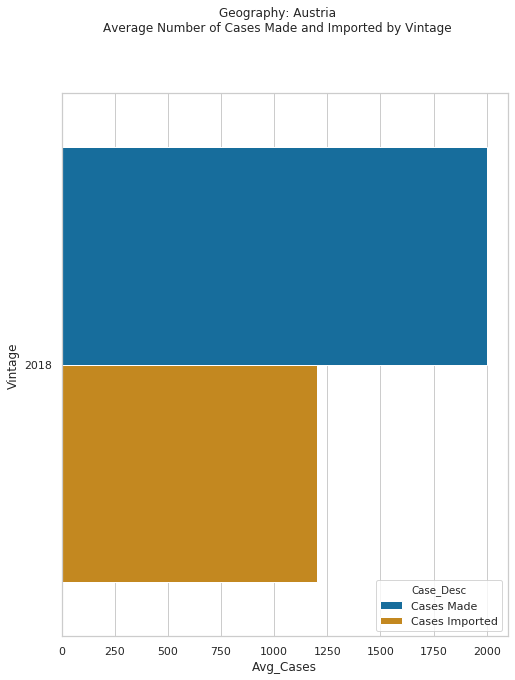

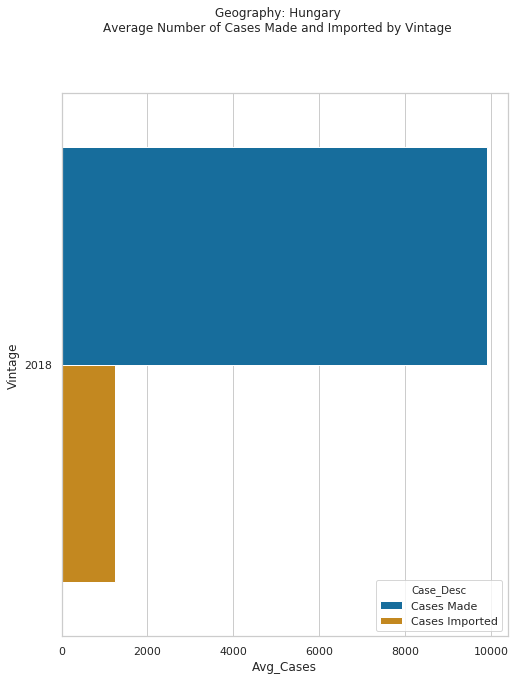

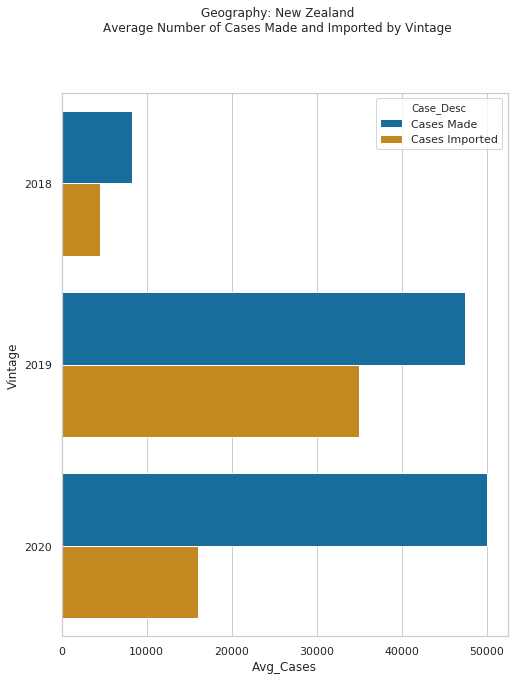

In [394]:
addresses = df_Cases_A.Address.unique()
addresses

for address in addresses:
    gpbar('address', address)